In [1]:
# Install required packages
%pip install -qU langchain langgraph langgraph-swarm langchain-google-genai google-generativeai langchain_community faiss-cpu tavily-python google-cloud-speech sounddevice scipy pdfminer.six python-dotenv langchain-openai numpy pandas pytesseract pdf2image openpyxl

Note: you may need to restart the kernel to use updated packages.


## 1. Setup and Imports

Install necessary libraries and import required modules.


In [2]:
# Install required packages (uncomment if needed)
#%pip install -qU langchain langgraph langgraph-swarm langchain-google-genai langchain_community faiss-cpu tavily-python google-cloud-speech sounddevice scipy pdfminer.six python-dotenv langchain-openai

import os
import json
import re
import uuid
import numpy as np
import pandas as pd # pandas is imported here
import sounddevice as sd
import scipy.io.wavfile as wav
from typing import List, Dict, Any, Optional, TypedDict

# Replace Ollama with Google Generative AI (Gemini)
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
# from langchain_ollama.chat_models import ChatOllama
# from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# Use pydantic.v1 for compatibility as suggested by the warning
from pydantic.v1 import BaseModel, Field 
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage
from langchain_core.tools import tool

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode, tools_condition
# Removed unused langgraph_swarm imports

from google.cloud import speech
from pdfminer.high_level import extract_text
from dotenv import load_dotenv

# Load environment variables (for API keys like Tavily, Google Cloud)
load_dotenv()

# --- Configuration ---
FAISS_RESUME_PATH = "./faiss/resume_embeddings"
FAISS_JD_PATH = "./faiss/jd_embeddings"
FAISS_RUBRIC_PATH = "./faiss/rubric_embeddings"
FAISS_KNOWLEDGE_PATH = "./faiss/knowledge_embeddings"
os.makedirs(os.path.dirname(FAISS_RESUME_PATH), exist_ok=True)
os.makedirs(os.path.dirname(FAISS_JD_PATH), exist_ok=True)
os.makedirs(os.path.dirname(FAISS_RUBRIC_PATH), exist_ok=True)
os.makedirs(os.path.dirname(FAISS_KNOWLEDGE_PATH), exist_ok=True)
# Retrieve the API key loaded by load_dotenv()
google_api_key = os.getenv("GOOGLE_API_KEY")

# Initialize LLM (using Gemini)
# Pass the API key explicitly
# import google.generativeai as genai
# genai.configure(api_key=google_api_key)
# models = genai.list_models()

# for m in models:
#     print(m.name, m.supported_generation_methods)
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",  # Must be valid in your project
    temperature=0.1,
    convert_system_message_to_human=True,
    google_api_key=google_api_key  # from .env
)
# llm = ChatOllama(model="llama3", temperature=0.1)

# Initialize Embeddings Model (using Gemini)
# Pass the API key explicitly
embeddings = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001",
    google_api_key=google_api_key
)
# embeddings = OllamaEmbeddings(model="nomic-embed-text")

# Initialize Checkpointer
memory = InMemorySaver()

/home/maya/soda-innovation-hacks/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Okay, I will update the interview-unlocked.ipynb notebook to implement the agentic workflow described in design.md using `langgraph` and `langgraph_swarm`.

Made changes.

OK. I have populated the interview-unlocked.ipynb notebook with the Python code to implement the multi-agent interview preparation system based on your design.md file and using LangGraph.

The notebook now contains the following sections:

1.  **Setup and Imports:** Installs necessary packages (commented out by default) and imports all required libraries and modules. It also sets up configurations like FAISS paths and initializes the LLM and embedding models.
2.  **Tool Definitions:** Implements all the tools required by the agents, such as text extraction, embedding generation, vector retrieval, web search, LeetCode retrieval (placeholder), audio recording/transcription, and evaluation helper tools (placeholders).
3.  **Agent Definitions:** Defines the `InterviewState` TypedDict to manage the data flow between agents. It includes the prompts for each agent (Preprocessing, Knowledge, Planner, Question, Evaluation) derived from design.md and sets up the agent nodes using LangGraph's `ToolNode` and a helper function.
4.  **Graph Definition:** Constructs the `StateGraph`, adds nodes for each agent and its tools, defines the sequential edges connecting them (Preprocessing -> Knowledge -> Planner -> Question -> Record Answer -> Evaluate -> END), and compiles the graph. It also includes code to optionally visualize the graph structure.
5.  **Execution and Interaction:** Provides an example of how to run the graph. You'll need to **modify the `resume_file` and `jd_file` variables** to point to your actual resume and job description files. It then runs the graph asynchronously, streams the events (like tool calls and LLM outputs), and finally prints the key outputs extracted from the final state (study plan, suggested LeetCode, generated question, transcribed answer, and evaluation feedback).

Please review the notebook, especially the placeholder file paths in the "Execution and Interaction" section, and ensure your environment (API keys, Ollama server if used, Google Cloud credentials) is set up correctly before running the cells.


# Interview Unlocked: Agentic Interview Preparation System

This notebook implements a multi-agent system using LangGraph and LangGraph Swarm to help users prepare for job interviews. It follows the design outlined in `design.md`.


In [3]:
# --- Tool Implementations ---

@tool
def extract_text_with_ocr(file_path: str) -> str:
    """
    Extracts text from a file. Uses pytesseract OCR for PDF files,
    otherwise reads as plain text.
    Requires Tesseract OCR engine to be installed and pdf2image library.
    """
    try:
        if file_path.lower().endswith('.pdf'):
            print(f"Extracting text from PDF using OCR: {file_path}")
            # Check if Tesseract is installed and accessible
            try:
                pytesseract.get_tesseract_version()
            except Exception as e:
                 return f"Tesseract is not installed or not in your PATH: {e}"

            try:
                images = convert_from_path(file_path)
                full_text = ""
                for i, image in enumerate(images):
                    print(f"Processing page {i+1}/{len(images)}...")
                    # Use pytesseract to do OCR on the image
                    text = pytesseract.image_to_string(image)
                    full_text += text + "\n" # Add newline between pages
                print("PDF OCR finished.")
                return full_text.strip()
            except Exception as e:
                return f"Error during PDF processing or OCR: {e}"
        else:
            # Handle non-PDF files as plain text
            print(f"Reading text file: {file_path}")
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                return f.read()
    except FileNotFoundError:
        return f"Error: File not found at {file_path}"
    except Exception as e:
        return f"An unexpected error occurred while processing {file_path}: {e}"

@tool
def generate_resume_embeddings_and_save(text: str) -> str:
    """Generates embeddings for the Job Description text and saves/updates the FAISS JD index."""
    index_path = FAISS_RESUME_PATH # Use the specific path
    try:
        texts = [text] # FAISS expects a list
        if os.path.exists(index_path):
            vectorstore = FAISS.load_local(index_path, embeddings, allow_dangerous_deserialization=True)
            vectorstore.add_texts(texts)
        else:
            vectorstore = FAISS.from_texts(texts, embeddings)
        vectorstore.save_local(index_path)
        return f"JD Embeddings generated and saved to {index_path}"
    except Exception as e:
        return f"Error generating/saving JD embeddings: {e}"

@tool
def generate_jd_embeddings_and_save(text: str) -> str:
    """Generates embeddings for the Job Description text and saves/updates the FAISS JD index."""
    index_path = FAISS_JD_PATH # Use the specific path
    try:
        texts = [text] # FAISS expects a list
        if os.path.exists(index_path):
            vectorstore = FAISS.load_local(index_path, embeddings, allow_dangerous_deserialization=True)
            vectorstore.add_texts(texts)
        else:
            vectorstore = FAISS.from_texts(texts, embeddings)
        vectorstore.save_local(index_path)
        return f"JD Embeddings generated and saved to {index_path}"
    except Exception as e:
        return f"Error generating/saving JD embeddings: {e}"

@tool
def generate_rubric_embeddings_and_save(text: str) -> str:
    """Generates embeddings for the Job Description text and saves/updates the FAISS JD index."""
    index_path = FAISS_RUBRIC_PATH # Use the specific path
    try:
        texts = [text] # FAISS expects a list
        if os.path.exists(index_path):
            vectorstore = FAISS.load_local(index_path, embeddings, allow_dangerous_deserialization=True)
            vectorstore.add_texts(texts)
        else:
            vectorstore = FAISS.from_texts(texts, embeddings)
        vectorstore.save_local(index_path)
        return f"JD Embeddings generated and saved to {index_path}"
    except Exception as e:
        return f"Error generating/saving JD embeddings: {e}"

@tool
def retrieve_resume_embeddings_from_vector_db(query: str, k: int = 3) -> List[str]:
    """Retrieves relevant documents from the resume FAISS index."""
    try:
        index_path = FAISS_RESUME_PATH
        if not os.path.exists(index_path):
            return ["Resume vector index not found."]
        vectorstore = FAISS.load_local(index_path, embeddings, allow_dangerous_deserialization=True)
        results = vectorstore.similarity_search(query, k=k)
        return [doc.page_content for doc in results]
    except Exception as e:
        return [f"Error retrieving from resume vector DB: {e}"]
    
@tool
def retrieve_jd_embeddings_from_vector_db(query: str, k: int = 3) -> List[str]:
    """Retrieves relevant documents from the resume FAISS index."""
    try:
        index_path = FAISS_JD_PATH
        if not os.path.exists(index_path):
            return ["Resume vector index not found."]
        vectorstore = FAISS.load_local(index_path, embeddings, allow_dangerous_deserialization=True)
        results = vectorstore.similarity_search(query, k=k)
        return [doc.page_content for doc in results]
    except Exception as e:
        return [f"Error retrieving from resume vector DB: {e}"]

@tool
def retrieve_rubric_embeddings_from_vector_db(query: str, k: int = 3) -> List[str]:
    """Retrieves relevant documents from the resume FAISS index."""
    try:
        index_path = FAISS_RUBRIC_PATH
        if not os.path.exists(index_path):
            return ["Resume vector index not found."]
        vectorstore = FAISS.load_local(index_path, embeddings, allow_dangerous_deserialization=True)
        results = vectorstore.similarity_search(query, k=k)
        return [doc.page_content for doc in results]
    except Exception as e:
        return [f"Error retrieving from resume vector DB: {e}"]

# Load environment variables from .env file
load_dotenv()

# Retrieve the API key from environment variables
tavily_api_key = os.getenv("TAVILY_API_KEY")

# Check if the API key was loaded
if not tavily_api_key:
    raise ValueError("TAVILY_API_KEY not found in environment variables. Please ensure it is set in your .env file.")

# Tavily Search Tool (already integrated in LangChain)
# Pass the API key during initialization
tavily_tool = TavilySearchResults(
   # name="websearcher_tool",
    description=(
        "Use this tool to search the web for real-world interview experiences, coding round expectations, "
        "and evaluation rubrics for specific companies. Focus on results mainly from Leetcode discussions, Reddit, Glassdoor and stackoverflow"
        "Your goal is to find behavioral insights — not code solutions — that reveal what"
        "companies look for in terms of communication, reasoning, and soft skills during interviews."
    ),
    tavily_api_key=tavily_api_key,
    max_results=20
)
results = tavily_tool.invoke("Amazon system design interview ")

@tool
def company_leetcode_problem_retriever(company: str, role_keywords: Optional[List[str]] = None) -> List[str]:
    """
    Retrieves suggested LeetCode questions for a specific company by reading
    from the './Leetcode-company-problem-set.xlsx' file. Each company's
    questions are expected to be in a sheet named after the company (case-insensitive).
    Questions are assumed to be listed in the first column (A) starting from the first row (A1).
    The role_keywords parameter is currently unused but available for future filtering.
    """
    excel_path = './Leetcode-company-problem-set.xlsx'
    default_questions = ["Reverse Linked List", "Valid Parentheses", "Coin Change"] # Default if company not found

    print(f"Fetching LeetCode questions for {company} from {excel_path}...")

    try:
        # Check if file exists first
        if not os.path.exists(excel_path):
            print(f"Error: Excel file not found at {excel_path}. Returning default questions.")
            return default_questions

        # Read all sheet names first to handle case-insensitivity
        xls = pd.ExcelFile(excel_path)
        sheet_names = xls.sheet_names
        target_sheet = None
        for name in sheet_names:
            if name.lower() == company.lower():
                target_sheet = name
                break

        if target_sheet:
            # Read the specific sheet, assuming no header and questions start at A1 (index 0)
            df = pd.read_excel(excel_path, sheet_name=target_sheet, header=None)

            if not df.empty and df.shape[1] > 0: # Check if dataframe is not empty and has at least one column
                 # Questions are in the first column (index 0)
                questions = df.iloc[:, 0].dropna().astype(str).tolist()
                if questions:
                    print(f"Found {len(questions)} questions for {company} in sheet '{target_sheet}'.")
                    return questions
                else:
                    print(f"Sheet '{target_sheet}' for {company} found, but the first column is empty or contains only NaN values.")
                    return default_questions
            else:
                print(f"Sheet '{target_sheet}' for {company} found but is empty or has no columns.")
                return default_questions
        else:
            print(f"No specific sheet found for '{company}'. Returning default questions.")
            return default_questions

    except FileNotFoundError: # Should be caught by os.path.exists, but kept for robustness
        print(f"Error: Excel file not found at {excel_path}. Returning default questions.")
        return default_questions
    except Exception as e:
        print(f"An error occurred while reading the Excel file for {company}: {e}. Returning default questions.")
        return default_questions


@tool
def record_and_transcribe_audio(duration: int = 15, fs: int = 16000) -> str:
    """Records audio from the microphone for a specified duration and transcribes it using Google Cloud Speech-to-Text."""
    print(f"Recording audio for {duration} seconds... Speak now!")
    audio_file = f"/tmp/interview_answer_{uuid.uuid4()}.wav"
    try:
        # Record audio
        recording = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='float32')
        sd.wait()
        # Convert to int16 and save
        recording_int16 = np.int16(recording * 32767)
        wav.write(audio_file, fs, recording_int16)
        print("Audio recorded.")

        # Transcribe audio
        print("Transcribing audio...")
        client = speech.SpeechClient() # Assumes GOOGLE_APPLICATION_CREDENTIALS is set
        with open(audio_file, "rb") as f:
            content = f.read()
        audio = speech.RecognitionAudio(content=content)
        config = speech.RecognitionConfig(
            encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
            sample_rate_hertz=fs,
            language_code="en-US",
            enable_automatic_punctuation=True
        )
        response = client.recognize(config=config, audio=audio)
        os.remove(audio_file) # Clean up temporary file

        if not response.results:
            print("Transcription failed: No speech detected.")
            return "[No speech detected]"

        transcript = " ".join([result.alternatives[0].transcript for result in response.results])
        print(f"Transcription complete: {transcript}")
        return transcript.strip()
    except Exception as e:
        if os.path.exists(audio_file):
            os.remove(audio_file)
        error_msg = f"Error during audio recording or transcription: {e}"
        print(error_msg)
        return error_msg

# --- Tools for Evaluation Agent (Simulated - LLM will act based on prompt) ---
# In a full implementation, these might call separate LLMs or specific logic.
@tool
def retrieve_rubric_snippets(query: str, company_tag: str, top_k: int = 3, index_path: str = FAISS_RUBRIC_PATH) -> str:
    """Retrieves relevant rubric snippets from the FAISS index."""
    results = retrieve_from_vector_db(query=f"{query} {company_tag}", index_path=index_path, k=top_k)
    return "\n".join(results)

# TODO Retrieve knowledge snippets from the FAISS index 

@tool
def generate_ideal_answer(question: str, company_tag: Optional[str] = None) -> str:
    """Generates an ideal answer to the question (simulated by LLM call)."""
    # This would typically involve another LLM call with specific instructions
    # For simplicity here, we'll just return a placeholder or let the main agent handle it.
    return f"[Placeholder: Ideal answer generation for '{question}' considering company '{company_tag}']"

@tool
def rewrite_candidate_answer(question: str, candidate_answer: str) -> str:
    """Rewrites the candidate's answer for improvement (simulated by LLM call)."""
    return f"[Placeholder: Rewritten version of answer for '{question}']"

@tool
def critique_and_advise(question: str, candidate_answer: str, ideal_answer: str, company_tag: Optional[str] = None) -> str:
    """Provides critique and advice based on the answers (simulated by LLM call)."""
    return f"[Placeholder: Critique for answer to '{question}' considering company '{company_tag}']"

## 3. Agent Definitions

Define the state, prompts, and nodes for each agent.


In [ ]:
# --- Agent State ---
class InterviewState(TypedDict):
    messages: List[Any] # Stores the conversation history
    user_resume_path: Optional[str]
    user_jd_path: Optional[str]
    user_resume_text: Optional[str]
    user_jd_text: Optional[str]
    clean_resume: Optional[str]
    clean_jd: Optional[str]
    company_name: Optional[str]
    knowledge_output: Optional[Dict[str, Any]] # Output from Knowledge Agent
    planner_output: Optional[Dict[str, Any]] # Output from Planner Agent (study plan, etc.)
    preferred_question_type: Optional[str]
    generated_question: Optional[str]
    candidate_answer: Optional[str]
    evaluation_output: Optional[Dict[str, Any]] # Output from Evaluation Agent
    current_agent: str # Tracks which agent's turn it is

# --- Agent Prompts (from design.md) ---

preprocessing_prompt = ChatPromptTemplate.from_messages([
        (
        "system",
        """
You are **PreprocessingAgent**, a specialist in structuring résumé and
job‑description text for downstream analysis.

**Your steps**

1. Run `extract_text_with_ocr` on both files whose paths are provided.
2. Clean the extracted text (strip headers/footers, extra whitespace,
   decorative lines) → store as **clean_resume** and **clean_jd**.
3. Detect the company name in `clean_jd`.  If nothing obvious, use
   "Company".
4. Call `generate_embeddings_and_save` once for each cleaned document:
     • résumé  →  ../faiss/resume_embeddings  
     • JD      →  ../faiss/jd_embeddings
5. **Return exactly** the JSON object below (and nothing else):

{{
  "clean_jd": "<cleaned job description>",
  "company_name": "<extracted company name>"
}}

(The graph will merge that JSON into state and pass it to the next agent.)
        """,
    ),
    (
        "human",
        "Resume: {user_resume_path}\n"
        "Job‑Description: {user_jd_path}\n\n"
        "Please begin preprocessing.",
    ),
    MessagesPlaceholder(variable_name="messages"),
])


knowledge_prompt = ChatPromptTemplate.from_messages([
    ("system", """
You are the Knowledge Agent in a multi-agent interview preparation system. Your role is to extract real-world, subjective expectations about how top companies evaluate technical candidates during interviews. You must infer the evaluation rubric, communication expectations, common patterns, and failure modes using a web search tool.

## Tools Available:

### 1. `tavily_tool` (Powered by Tavily)
- Performs web search queries across Reddit, Glassdoor, Blind, Medium, and other platforms.
- Returns concise snippets and links, not full articles.
- Snippets often contain behavioral signals or reflections from interviewees.

### 2. `generate_embeddings`
- Accepts a list of web snippets with metadata.
- Converts them into embeddings.
- Saves them to a FAISS index at `./faiss/search_results`.

---

## Inputs:
- `target_company` (string): The company to analyze (e.g., "Amazon").
- `clean_jd` (string): The job description text.
- `max_snippets` (int): Max search results to retrieve (default: 20).

---

## Search Strategy:
Construct at least 4 queries using variations like:
- `{company} coding interview expectations site:reddit.com`
- `{company} behavioral interview rubric site:glassdoor.com`
- `{company} system design interview site:blind.com`
- `{company} interview debrief site:medium.com`

---

## Goals:
1. Use `websearcher_tool` to collect search result snippets about the company’s interview process.
2. For each snippet, analyze and infer themes such as:
   - Ownership
   - Tradeoff Thinking
   - Structured Reasoning
   - Handling Ambiguity
   - Communication Style
3. Cluster the themes and summarize them as a list of `inferred_rubric` items.
4. From the language and tone of the snippets, extract 3–5 actionable `communication_tips`.
5. Record common topics or questions discussed in snippets (optional).
6. Pass the snippet list and associated metadata into `generate_embeddings` to persist them in FAISS.

---

## Output Format:
Return a JSON object in the format:
```json

  "company": "Amazon",
  "inferred_rubric": [
    
      "theme": "Ownership",
      "evidence": "Multiple Reddit users reported being asked how they would proactively handle fallback strategies.",
      "discussion_reference": "https://www.reddit.com/r/csMajors/comments/abc123"
    ,
    
      "theme": "Tradeoff Thinking",
      "evidence": "Glassdoor snippets emphasize discussing time-space tradeoffs during implementation decisions.",
      "discussion_reference": "https://www.glassdoor.com/Interview/Amazon-Interview-Questions.htm"
    
  ],
  "communication_tips": [
    "Narrate your approach clearly before coding.",
    "Always explain tradeoffs when discussing solutions.",
    "Discuss scalability and edge case assumptions upfront."
  ]

```

"""),
    ("human", "Generate interview insights for {company_name}. Resume context (optional): {user_resume_text}. JD context (optional): {clean_jd}"),
    MessagesPlaceholder(variable_name="messages"),
])

planner_prompt = ChatPromptTemplate.from_messages([
    ("system", """
You are the Planner Agent, orchestrating interview preparation.
**Inputs You Have Access To (implicitly via state or tools)**:
- Parsed Resume Context (from ../faiss/resume_embeddings )
- Parsed Job Description Context (from ../faiss/jd_embeddings )
- Knowledge Agent Output: `inferred_rubric` and `communication_tips` for `{company_name}`.
- User Preference: `preferred_question_type` (e.g., 'technical', 'behavioral').

**Your Responsibilities**:
1.  **Synthesize**: Briefly analyze the alignment between resume, JD, and company insights.
2.  **Generate Study Plan**: Create a concise, actionable study plan (markdown format).
3.  **Suggest LeetCode**: Call `company_leetcode_retriever` for `{company_name}`.
4.  **Present Insights**: Format and include the `inferred_rubric` and `communication_tips` in your output.
5.  **Embed Insights**: Call `generate_embeddings_and_save` to save the combined text of the rubric and tips to `{FAISS_RUBRIC_PATH}`.
6.  **Prepare for Question Agent**: Note the `preferred_question_type` for the next step.

**Output Format**:
Return **only** a JSON object like this:
```json
{{
  "study_plan": "<Markdown formatted study plan>",
  "suggested_leetcode": ["<LeetCode Q1>", "<LeetCode Q2>"],
  "company_insights_display": {{
    "company": "{company_name}",
    "inferred_rubric": [ ... ],
    "communication_tips": [ ... ]
  }},
  "embedding_status": "<Status message from generate_embeddings_and_save>",
  "next_action": "Proceed to generate a '{preferred_question_type}' question."
}}
"""
    ),
    ("human", "Plan the interview prep for {company_name} based on the available context and user preference for a '{preferred_question_type}' question. Knowledge Agent output: {knowledge_output}"),
    MessagesPlaceholder(variable_name="messages"),
])

question_prompt = ChatPromptTemplate.from_messages([
    ("system", """
You are the Question Agent. Your goal is to generate a single, relevant, open-ended interview question.
**Inputs You Have Access To (implicitly via state or tools)**:
- Question Type Requested: `{preferred_question_type}`
- Company: `{company_name}`
- Contextual Data (via `retrieve_from_vector_db` from ../faiss/resume_embeddings, ../faiss/jd_embeddings, `{FAISS_RUBRIC_PATH}`)

**Your Task**:
1. Call `retrieve_from_vector_db` using relevant queries (e.g., job title, key skills, company name, question type) against the resume, JD, and rubric indices to gather context.
2. Synthesize the retrieved context.
3. Generate **one** interview question of the type `{preferred_question_type}` that is:
    - Tailored to the company (`{company_name}`).
    - Relevant to the job description and candidate's likely experience.
    - Aligned with the company's inferred rubric/culture (if available).
    - Clear, professional, and open-ended.

**Output Format**:
Return **only** a JSON object like this:
```json
{{
  "question": "<The generated interview question>"
}}
```
"""),
    ("human", "Generate a '{preferred_question_type}' question for {company_name} based on the available context."),
    MessagesPlaceholder(variable_name="messages"),
])

evaluation_prompt = ChatPromptTemplate.from_messages([
    ("system", """
You are EvaluationFeedbackAgent, a senior interview coach.
**Given**:
- question: `{generated_question}`
- candidate_answer: `{candidate_answer}`
- company_tag: `{company_name}`
- rubric_index_path: `{FAISS_RUBRIC_PATH}`

**Do the following**:
1. Call `retrieve_rubric_snippets` using the `question` and `company_tag` to get relevant evaluation criteria.
2. Call `generate_ideal_answer` for the `question` and `company_tag`.
3. Call `rewrite_candidate_answer` for the `question` and `candidate_answer`.
4. Call `critique_and_advise` using all inputs.
   - The critique must highlight strengths, list missed elements (e.g., complexity, STAR method), suggest improvements, use bullet points, and bold key terms.

**Output Format**:
Return **only** this JSON:
```json
{{
    "ideal_answer": "<Output from generate_ideal_answer>",
    "improved_answer": "<Output from rewrite_candidate_answer>",
    "detailed_feedback": "<Output from critique_and_advise>"
}}
```
"""),
    ("human", "Evaluate the answer '{candidate_answer}' for the question '{generated_question}' for company '{company_name}'."),
    MessagesPlaceholder(variable_name="messages"),
])


# --- Agent Nodes ---
# Helper to create agent nodes
# async def preprocess_agent_node(state: InterviewState, config: dict):
#     print("\n🔧 Running preprocess agent manually...")

#     # Extract paths
#     resume_path = state["user_resume_path"]
#     jd_path = state["user_jd_path"]

#     # Extract raw text
#     resume_text = extract_text_with_ocr.invoke(resume_path)
#     jd_text = extract_text_with_ocr.invoke(jd_path)

#     # Simple clean of JD
#     clean_jd = re.sub(r"[^\S\r\n]+", " ", jd_text.strip())  # Remove excessive whitespace
#     clean_jd = re.sub(r"(?m)^[=_\\-]{3,}$", "", clean_jd)   # Remove decorative lines

#     # Try extracting company name (super basic fallback)
#     company_match = re.search(r"(?:at|join)\s+([A-Z][a-zA-Z0-9& ]+)", clean_jd)
#     company_name = company_match.group(1).strip() if company_match else "Unknown"

#     # Generate embeddings and save
#     generate_resume_embeddings_and_save.invoke({"text": resume_text})
#     generate_jd_embeddings_and_save.invoke({"text": clean_jd})

#     # Update state
#     state["user_resume_text"] = resume_text
#     state["user_jd_text"] = jd_text
#     state["clean_jd"] = clean_jd
#     state["company_name"] = company_name

#     print(f"\n✅ Preprocess Complete. Extracted company: {company_name}")
#     return {"messages": []}

def create_agent_node(prompt: ChatPromptTemplate, tools: List[Any]):
    agent = prompt | llm.bind_tools(tools)
    tool_executor = ToolNode(tools)
    async def agent_node(state: InterviewState, config: dict):
        print(f"\n📤 Sending to {state.get('current_agent')}:")
        print(json.dumps(state, indent=2, default=str))

        try:
            result = await agent.ainvoke(state, config)
            print(f"\n🧾 Raw LLM output for agent {state.get('current_agent')}:")
            print(result.content)

        except Exception as e:
            print(f"\n❌ Error during ainvoke for agent {state.get('current_agent', 'unknown')}: {e}")
            raise
        # If tool calls are requested
        if isinstance(result, ToolMessage) or (isinstance(result, AIMessage) and result.tool_calls):
             # We delegate to the ToolNode
            return {"messages": [result]}
        else:
            # If no tool calls, return the result directly
            # Attempt to parse JSON output if expected
            try:
                if isinstance(result.content, str) and result.content.strip().startswith('{'):
                    parsed_output = json.loads(result.content)
                    # Update state based on agent
                    agent_name = state.get('current_agent', 'unknown')
                    if agent_name == 'preprocess':
                        print("✅ Fields in parsed_output:", list(parsed_output.keys()))
                        state['clean_jd'] = parsed_output.get('clean_jd')
                        state['user_resume_text'] = parsed_output.get('user_resume_text')  # Add this
                        state['user_jd_text'] = parsed_output.get('clean_jd')
                        state['company_name'] = parsed_output.get('company_name')
                    elif agent_name == 'knowledge':
                        state['knowledge_output'] = parsed_output
                    elif agent_name == 'planner':
                        state['planner_output'] = parsed_output
                    elif agent_name == 'question':
                        state['generated_question'] = parsed_output.get('question')
                    elif agent_name == 'evaluate':
                        state['evaluation_output'] = parsed_output
            except json.JSONDecodeError:
                print(f"Warning: Could not parse JSON output from {state.get('current_agent', 'agent')}")
                # Fallback or handle error as needed
            return {"messages": [result]}
    return agent_node, tool_executor

# Create nodes
preprocess_tools = [extract_text_with_ocr, generate_resume_embeddings_and_save, generate_jd_embeddings_and_save]
preprocess_agent_node, preprocess_tool_node = create_agent_node(preprocessing_prompt, preprocess_tools)

knowledge_tools = [tavily_tool, generate_resume_embeddings_and_save, generate_jd_embeddings_and_save]
knowledge_agent_node, knowledge_tool_node = create_agent_node(knowledge_prompt, knowledge_tools)

planner_tools = [company_leetcode_problem_retriever, generate_resume_embeddings_and_save, generate_jd_embeddings_and_save, generate_rubric_embeddings_and_save]
planner_agent_node, planner_tool_node = create_agent_node(planner_prompt, planner_tools)

question_tools = [retrieve_jd_embeddings_from_vector_db,retrieve_rubric_embeddings_from_vector_db]
question_agent_node, question_tool_node = create_agent_node(question_prompt, question_tools)

evaluation_tools = [retrieve_resume_embeddings_from_vector_db,retrieve_jd_embeddings_from_vector_db,retrieve_rubric_embeddings_from_vector_db,retrieve_rubric_snippets, generate_ideal_answer, rewrite_candidate_answer, critique_and_advise]
evaluation_agent_node, evaluation_tool_node = create_agent_node(evaluation_prompt, evaluation_tools)

NameError: name 'generate_embeddings_and_save' is not defined

## 4. Graph Definition

Define the workflow connecting the agents.


Graph compiled successfully!


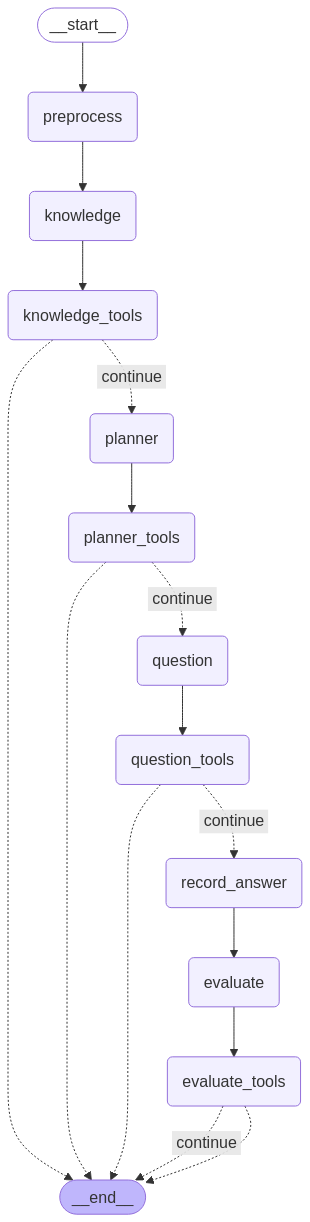

In [ ]:
# --- Graph Construction ---
workflow = StateGraph(InterviewState)

# # Add nodes for each agent and their tools
workflow.add_node("preprocess", preprocess_agent_node)
# Override the node with the manual version
# workflow.add_node("preprocess", manual_preprocess_agent_node)
# workflow.add_node("preprocess_tools", preprocess_tool_node)
workflow.add_node("knowledge", knowledge_agent_node)
workflow.add_node("knowledge_tools", knowledge_tool_node)
workflow.add_node("planner", planner_agent_node)
workflow.add_node("planner_tools", planner_tool_node)
workflow.add_node("question", question_agent_node)
workflow.add_node("question_tools", question_tool_node)
workflow.add_node("record_answer", record_and_transcribe_audio) # Direct tool call node
workflow.add_node("evaluate", evaluation_agent_node)
workflow.add_node("evaluate_tools", evaluation_tool_node)

# Define edges
workflow.set_entry_point("preprocess")

# Preprocessing Agent Logic
workflow.add_edge("preprocess", "preprocess_tools")
workflow.add_conditional_edges(
    "preprocess_tools",
    tools_condition,
    {"continue": "knowledge", END: END} # If tool call needed, loop back via tools_condition, else go to knowledge
)
# workflow.add_edge("preprocess", "knowledge")

# Knowledge Agent Logic
workflow.add_edge("knowledge", "knowledge_tools")
workflow.add_conditional_edges(
    "knowledge_tools",
    tools_condition,
    {"continue": "planner", END: END}
)

# Planner Agent Logic
workflow.add_edge("planner", "planner_tools")
workflow.add_conditional_edges(
    "planner_tools",
    tools_condition,
    {"continue": "question", END: END}
)

# Question Agent Logic
workflow.add_edge("question", "question_tools")
workflow.add_conditional_edges(
    "question_tools",
    tools_condition,
    {"continue": "record_answer", END: END} # After question is generated, record answer
)

# Record Answer Node
workflow.add_edge("record_answer", "evaluate") # After recording, go to evaluation

# Evaluation Agent Logic
workflow.add_edge("evaluate", "evaluate_tools")
workflow.add_conditional_edges(
    "evaluate_tools",
    tools_condition,
    {"continue": END, END: END} # End after evaluation
)

# Compile the graph
graph = workflow.compile(checkpointer=memory)

print("Graph compiled successfully!")
# Optional: Visualize the graph
try:
    from IPython.display import Image, display
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}. Make sure graphviz and mermaid are installed/configured.")

## 5. Execution and Interaction

Run the graph with user inputs.


In [ ]:
import asyncio
import pprint

# --- Execution ---

# IMPORTANT: Set the path to your Google Cloud credentials file
# This is needed for the record_and_transcribe_audio tool
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "key.json" # Replace with the actual path to your key.json

# --- User Inputs ---
# !!! IMPORTANT: Replace these with the actual paths to your files !!!
resume_file = os.path.join(os.getcwd(), "Resume_Mayank_Vyas-ML-2.pdf") # e.g., "/path/to/your/resume.pdf"
jd_file = os.path.join(os.getcwd(), "amazon-jd.txt") #"/path/to/your/job_description.txt"
user_preferred_question_type = "technical" # Options: "technical", "behavioral", "system design", "debugging/problem-solving"

# Create dummy files if they don't exist for the example run
if not os.path.exists(resume_file):
    with open(resume_file, "w") as f:
        f.write("Sample Resume Content: Python Developer with 5 years experience in web development and data analysis.")
if not os.path.exists(jd_file):
     with open(jd_file, "w") as f:
        f.write("Sample Job Description: Looking for a Senior Software Engineer at Google. Requires strong Python skills, experience with distributed systems, and cloud platforms.")

# Define the initial state to start the graph
initial_state = {
    "messages": [],
    "user_resume_path": resume_file,
    "user_jd_path": jd_file,
    "preferred_question_type": user_preferred_question_type,
    "current_agent": "preprocess" # Start with the preprocessing agent
}

# Configuration for the graph run (e.g., unique thread ID)
config = {"configurable": {"thread_id": "interview-prep-thread-1"}}

async def run_graph():
    final_state = None
    print("--- Starting Interview Prep Workflow ---")
    print(f"Resume: {resume_file}")
    print(f"Job Description: {jd_file}")
    print(f"Preferred Question Type: {user_preferred_question_type}")
    print("-" * 30)

    async for event in graph.astream_events(initial_state, config, version="v1"):
        kind = event["event"]
        tags = event.get("tags", [])
        if kind == "on_chat_model_stream":
            content = event["data"]["chunk"].content
            if content:
                # Print LLM tokens as they arrive
                print(content, end="|")
        elif kind == "on_tool_start":
            print(f"\n--- Calling Tool: {event['name']} ---")
            print(f"   Args: {event['data'].get('input')}")
        elif kind == "on_tool_end":
            print(f"--- Tool Result: {event['name']} ---")
            print(f"   Output: {event['data'].get('output')}")
            print("-" * 30)
        elif kind == "on_chain_end":
             # Check if it's the end of a specific agent node run
            if event["name"] in ["preprocess", "knowledge", "planner", "question", "evaluate"]:
                 print(f"\n--- Finished Agent: {event['name']} ---")
                 # pprint.pprint(event['data'].get('output'), indent=2) # Print agent output if needed
                 print("-" * 30)


        # Track the final state
        if kind == "on_graph_end":
            final_state = event['data']['output']


    print("\n--- Workflow Complete ---")

    if final_state:
        print("\n--- Final Results ---")
        # Extract and print key information from the final state
        planner_output = final_state.get('planner_output', {})
        evaluation_output = final_state.get('evaluation_output', {})

        print("\n**Study Plan:**")
        print(planner_output.get('study_plan', 'Not generated.'))

        print("\n**Suggested LeetCode:**")
        pprint.pprint(planner_output.get('suggested_leetcode', 'Not generated.'))

        print("\n**Company Insights:**")
        pprint.pprint(planner_output.get('company_insights_display', 'Not generated.'))

        print(f"\n**Generated Question ({final_state.get('preferred_question_type', 'N/A')}):**")
        print(final_state.get('generated_question', 'Not generated.'))

        print("\n**Your Transcribed Answer:**")
        # The actual transcribed answer isn't directly stored in the state by the tool node,
        # but it was passed to the evaluation agent. We print the placeholder for clarity.
        # In a real UI, you'd capture the output of the 'record_answer' node.
        print(final_state.get('candidate_answer', '[Answer was recorded and passed to evaluation]'))


        print("\n**Evaluation Feedback:**")
        print("\n*Ideal Answer (Placeholder):*")
        print(evaluation_output.get('ideal_answer', 'Not generated.'))
        print("\n*Improved Answer (Placeholder):*")
        print(evaluation_output.get('improved_answer', 'Not generated.'))
        print("\n*Detailed Feedback (Placeholder):*")
        print(evaluation_output.get('detailed_feedback', 'Not generated.'))
    else:
        print("Workflow did not complete successfully or final state not captured.")

# Run the asynchronous function
import traceback

try:
    await run_graph()
except Exception as e:
    print("\nAn error occurred during graph execution:")
    traceback.print_exc()



--- Starting Interview Prep Workflow ---
Resume: /home/maya/soda-innovation-hacks/interview-unlocked/Resume_Mayank_Vyas-ML-2.pdf
Job Description: /home/maya/soda-innovation-hacks/interview-unlocked/amazon-jd.txt
Preferred Question Type: technical
------------------------------

📤 Sending to preprocess:
{
  "messages": [],
  "user_resume_path": "/home/maya/soda-innovation-hacks/interview-unlocked/Resume_Mayank_Vyas-ML-2.pdf",
  "user_jd_path": "/home/maya/soda-innovation-hacks/interview-unlocked/amazon-jd.txt",
  "preferred_question_type": "technical",
  "current_agent": "preprocess"
}


/home/maya/soda-innovation-hacks/.venv/lib/python3.12/site-packages/langchain_google_genai/chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  tool_messages_parts = _get_ai_message_tool_messages_parts(



🧾 Raw LLM output for agent preprocess:


--- Finished Agent: preprocess ---
------------------------------

📤 Sending to preprocess:
{
  "messages": [
    "content='' additional_kwargs={'function_call': {'name': 'extract_text_with_ocr', 'arguments': '{\"file_path\": \"/home/maya/soda-innovation-hacks/interview-unlocked/amazon-jd.txt\"}'}} response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run-e5ef3e32-e332-4520-ac0f-2ff7ab917333' tool_calls=[{'name': 'extract_text_with_ocr', 'args': {'file_path': '/home/maya/soda-innovation-hacks/interview-unlocked/Resume_Mayank_Vyas-ML-2.pdf'}, 'id': 'ad6abb8c-5571-47b0-b534-e4a452cbdf58', 'type': 'tool_call'}, {'name': 'extract_text_with_ocr', 'args': {'file_path': '/home/maya/soda-innovation-hacks/interview-unlocked/amazon-jd.txt'}, 'id': 'fa6e3747-a58e-4e3c-a9bc-c50135257f2a', 'type': 'tool_call'}] usage_metadata={'input_tokens': 457, 'output_tokens': 68, 'total_tokens': 525, 'input_token_detail

Traceback (most recent call last):
  File "/tmp/ipykernel_239519/1339185812.py", line 113, in <module>
    await run_graph()
  File "/tmp/ipykernel_239519/1339185812.py", line 44, in run_graph
    async for event in graph.astream_events(initial_state, config, version="v1"):
  File "/home/maya/soda-innovation-hacks/.venv/lib/python3.12/site-packages/langchain_core/runnables/base.py", line 1394, in astream_events
    async for event in event_stream:
  File "/home/maya/soda-innovation-hacks/.venv/lib/python3.12/site-packages/langchain_core/tracers/event_stream.py", line 790, in _astream_events_implementation_v1
    async for log in _astream_log_implementation(
  File "/home/maya/soda-innovation-hacks/.venv/lib/python3.12/site-packages/langchain_core/tracers/log_stream.py", line 702, in _astream_log_implementation
    await task
  File "/usr/lib/python3.12/asyncio/futures.py", line 290, in __await__
    return self.result()  # May raise too.
           ^^^^^^^^^^^^^
  File "/usr/lib/python